In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Functional Analysis of NBA Player Career Trajectory 

$$ y(t) = X\Phi(t) + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \Sigma) $$
where $\Phi(t)$ is a functional. Here, we let $X$ be fixed set of covariates (initially)

In [2]:
data = pd.read_csv("data/player_data.csv")

In [65]:
data.head()

,year,season,id,minutes,fg2m,fg2a,fg3a,fg3m,ftm,fta,...,position,team,age,obpm,dbpm,bpm,games,total_seasons,median_minutes_per_game,max_minutes
0,1997,1996-97,2,1439.778333,90,191,188,73,127,151,...,SG,LAL,35,0.6,0.4,1.0,79,1,18.225042,1439.778333
1,1997,1996-97,3,1170.195000,106,228,47,17,63,84,...,PF,DET,30,-1.0,0.3,-0.6,65,7,21.958214,1868.101667
2,1998,1997-98,3,741.726667,50,113,4,0,41,57,...,PF,DET,31,-2.6,1.5,-1.1,40,7,21.958214,1868.101667
3,1999,1998-99,3,1380.178333,148,341,18,3,184,235,...,PF,ATL,32,-0.3,1.7,1.5,50,7,21.958214,1868.101667
4,2000,1999-00,3,922.245000,74,163,4,0,55,71,...,PF,VAN,33,-1.9,0.3,-1.7,42,7,21.958214,1868.101667


In [3]:
def process_data(df, output_metric, exposure, model, input_metrics):

    agg_dict = {input_metric:"max" for input_metric in input_metrics}
    df = df.sort_values(by=["id","year"])
    df["ft_pct"] = df["ftm"] / df["fta"]
    df["three_pct"] = df["fg3m"] / df["fg3a"]
    df["two_pct"] = df["fg2m"] / df["fg2a"]
    X = df[input_metrics + ["id"]].groupby("id").agg(agg_dict).reset_index()[input_metrics]
    metric_df = df[[output_metric, "id", "age"]]
    exposure_df = df[["id", "age", exposure]]
    games_df = df[["id", "age", "games"]]
    metric_df  = metric_df.pivot(columns="age",values=output_metric,index="id")
    if model == "poisson":
        offset = np.log(exposure_df.pivot(columns="age", values=exposure,index="id").to_numpy()) + np.log(games_df.pivot(columns="age", values = "games", index = "id").to_numpy())
        return offset, metric_df.to_numpy(), X
    elif model == "binomial":
        trials = exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy()
        return trials, metric_df.to_numpy(), X
    elif model == "gaussian":
        variance_scale = np.sqrt(exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy())
        return variance_scale, metric_df.to_numpy(), X
    return ValueError


In [7]:
exposure, Y, X = process_data(data, "obpm", "median_minutes_per_game", "gaussian", ["position_group"])

In [8]:
fixed_eff_matrix = np.insert(pd.get_dummies(X[["position_group"]], drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

### Build Model

Will use a HSGP as a prior on the weights of the basis function (3 x 27)



In [8]:
mask = np.isfinite(exposure)


In [4]:
basis = np.arange(18,45)
radial_basis_function = np.exp(-1/50*np.square(np.subtract.outer(basis,basis)))

In [45]:
with pm.Model() as fda_model:
    
    exposure_scale = pm.MutableData("exposure_scale", exposure[mask].flatten())
    radial_basis = pm.MutableData("radial_basis", radial_basis_function)
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.5)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    

    basis_weight_1 = gp.prior("basis_weights_1",X=basis[:,None])
    basis_weight_2 = gp.prior("basis_weights_2",X=basis[:,None])
    basis_weight_3 = gp.prior("basis_weights_3",X=basis[:,None])
    basis_weights = pm.Deterministic("basis_weights", pm.math.stack([basis_weight_1, basis_weight_2, basis_weight_3], axis = 0))
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    
    mu = pm.Deterministic("mu",pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis)) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu[mask]), sigma = sd / exposure_scale, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_1_hsgp_coeffs_, basis_weights_2_hsgp_coeffs_, basis_weights_3_hsgp_coeffs_, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1117 seconds.


/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='basis_weights\n0, 1'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 2'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 3'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 4'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 5'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 6'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 7'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='basis_weights\n0, 0', ylabel='basis_weights\n0, 8'>,
        <Axes: xlabel='basis_weights\n0, 1'>,
   

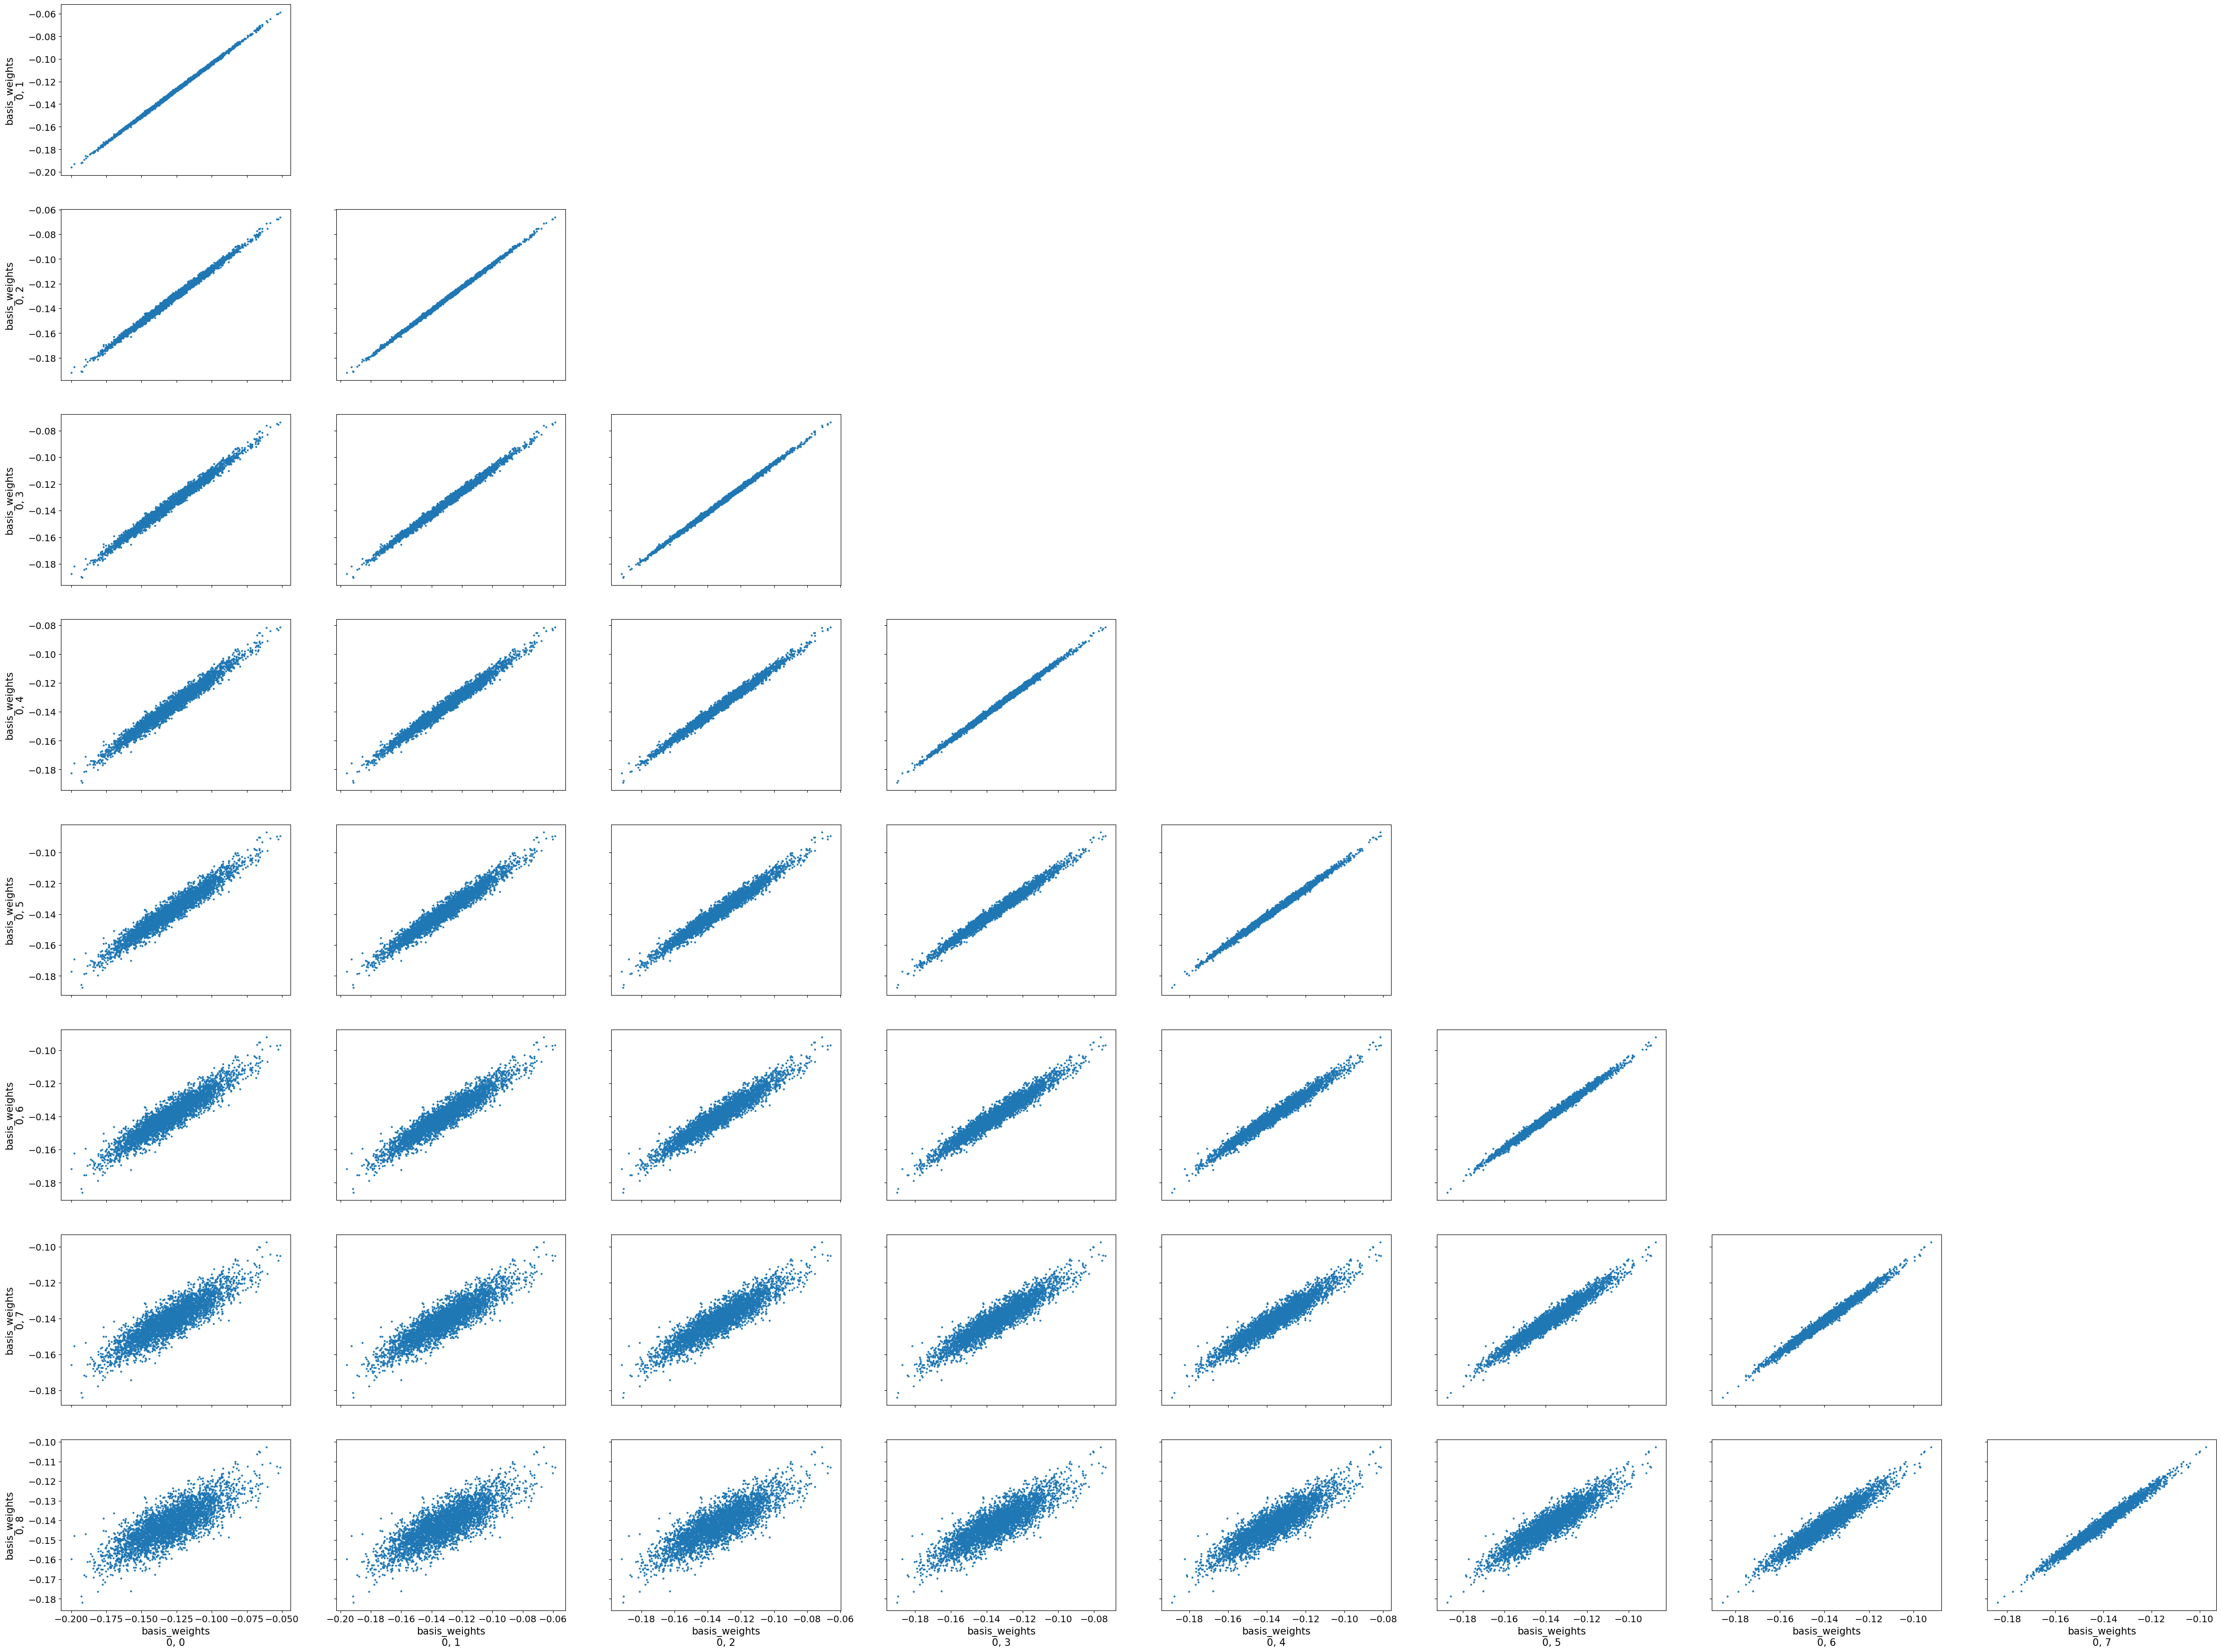

In [32]:
az.plot_pair(trace, var_names="basis_weights")

In [46]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-0.288,0.046,-0.371,-0.202,0.001,0.000,4477.0,3216.0,1.0
"basis_weights[0, 1]",-0.258,0.038,-0.331,-0.189,0.001,0.000,4482.0,3206.0,1.0
"basis_weights[0, 2]",-0.229,0.031,-0.285,-0.168,0.000,0.000,4468.0,3131.0,1.0
"basis_weights[0, 3]",-0.201,0.025,-0.244,-0.151,0.000,0.000,4422.0,3040.0,1.0
"basis_weights[0, 4]",-0.174,0.020,-0.210,-0.137,0.000,0.000,4393.0,2845.0,1.0
...,...,...,...,...,...,...,...,...,...
"basis_weights[2, 22]",0.067,0.051,-0.027,0.163,0.001,0.001,4338.0,3550.0,1.0
"basis_weights[2, 23]",0.051,0.060,-0.061,0.163,0.001,0.001,4375.0,3486.0,1.0
"basis_weights[2, 24]",0.035,0.069,-0.088,0.168,0.001,0.001,4401.0,3548.0,1.0
"basis_weights[2, 25]",0.020,0.078,-0.123,0.167,0.001,0.001,4425.0,3452.0,1.0


# Results

In [47]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()

In [48]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [49]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [37]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

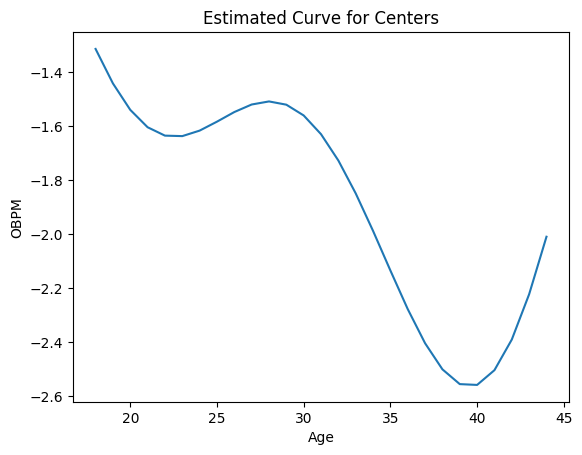

In [50]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

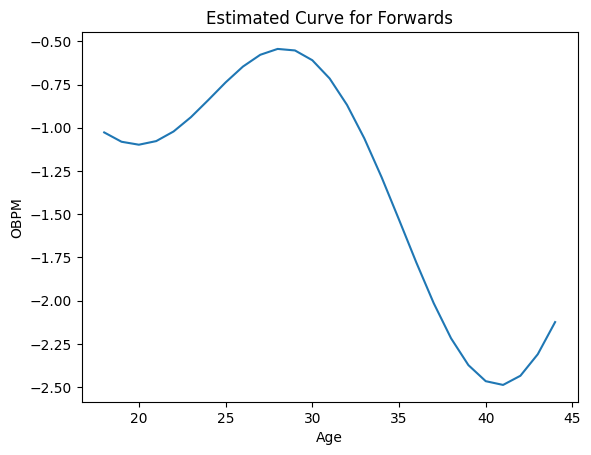

In [51]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

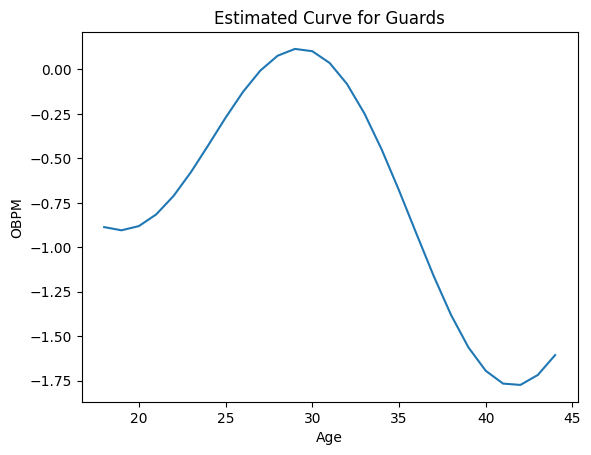

In [52]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

In [44]:
position_2_weights

array([0.089, 0.092, 0.095, 0.098, 0.101, 0.104, 0.107, 0.11 , 0.113,
       0.116, 0.119, 0.121, 0.124, 0.126, 0.128, 0.131, 0.133, 0.135,
       0.136, 0.138, 0.14 , 0.141, 0.142, 0.143, 0.144, 0.144, 0.144])

# Model 
Now we will just approximate the actual latent functional with a GP 

In [53]:
with pm.Model() as fda_model:
    
    exposure_scale = pm.MutableData("exposure_scale", exposure[mask].flatten())
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.5)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    

    basis_weight_1 = gp.prior("basis_weights_1",X=basis[:,None])
    basis_weight_2 = gp.prior("basis_weights_2",X=basis[:,None])
    basis_weight_3 = gp.prior("basis_weights_3",X=basis[:,None])
    basis_weights = pm.Deterministic("basis_weights", pm.math.stack([basis_weight_1, basis_weight_2, basis_weight_3], axis = 0))
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    
    mu = pm.Deterministic("mu", pm.math.dot(fixed_effects, basis_weights)) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu[mask]), sigma = sd / exposure_scale, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_1_hsgp_coeffs_, basis_weights_2_hsgp_coeffs_, basis_weights_3_hsgp_coeffs_, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


# Results

In [54]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-1.247,0.125,-1.477,-1.013,0.002,0.001,4382.0,3390.0,1.0
"basis_weights[0, 1]",-1.252,0.116,-1.463,-1.033,0.002,0.001,4501.0,3547.0,1.0
"basis_weights[0, 2]",-1.253,0.108,-1.445,-1.045,0.002,0.001,4679.0,3481.0,1.0
"basis_weights[0, 3]",-1.252,0.100,-1.440,-1.068,0.001,0.001,4938.0,3567.0,1.0
"basis_weights[0, 4]",-1.248,0.094,-1.421,-1.069,0.001,0.001,5283.0,3405.0,1.0
...,...,...,...,...,...,...,...,...,...
"basis_weights[2, 22]",0.374,0.165,0.068,0.689,0.002,0.002,4390.0,3363.0,1.0
"basis_weights[2, 23]",0.252,0.176,-0.080,0.578,0.003,0.002,4329.0,3364.0,1.0
"basis_weights[2, 24]",0.128,0.186,-0.206,0.490,0.003,0.002,4265.0,3306.0,1.0
"basis_weights[2, 25]",0.007,0.197,-0.351,0.383,0.003,0.003,4227.0,3168.0,1.0


In [55]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()


In [56]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [57]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


Text(0.5, 0, 'Age')

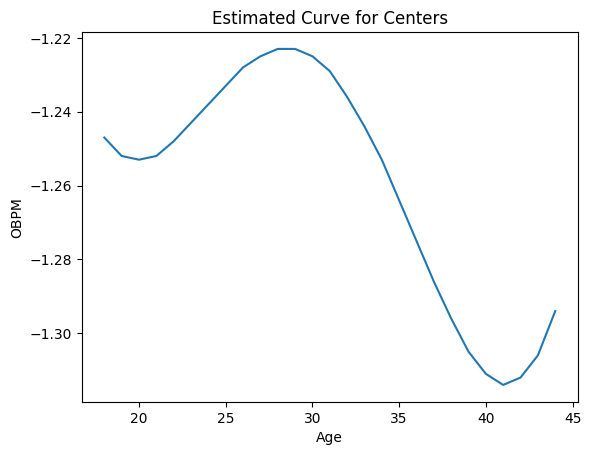

In [59]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

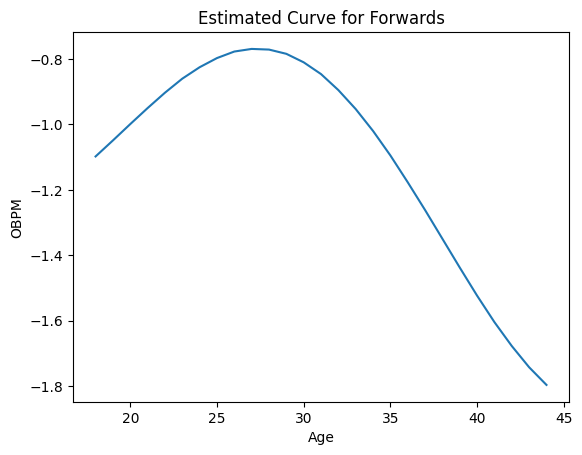

In [61]:
plt.plot(range(18,45), position_1_weights[:,np.newaxis] + position_0_weights[:, np.newaxis] )
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

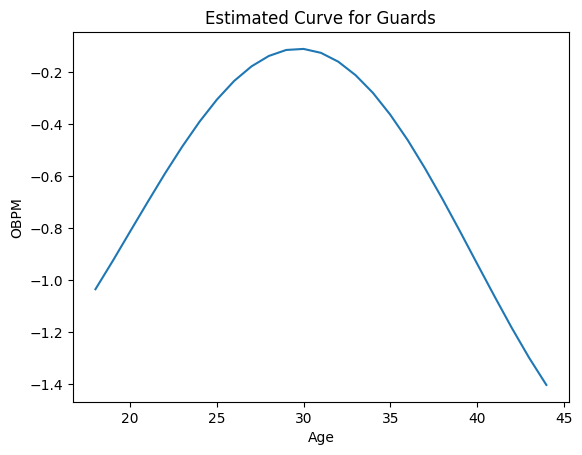

In [62]:
plt.plot(range(18,45), position_2_weights[:,np.newaxis] + position_0_weights[:, np.newaxis] )
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

### Fit All Metrics Independently 
We are going to fit all metrics independently with GP prior on the functional. There will be independent functionals for each metric.

In [5]:
metric_output = (["gaussian"] * 2) + (["poisson"] * 6) + (["binomial"] * 3)
metrics = ["obpm","dbpm","blk","stl","ast","dreb","oreb","tov","ftm","fg2m","fg3m"]
exposure_list = (["median_minutes_per_game"] * 8) + ["fta","fg2a","fg3a"]
covariate_size = 3
data_set = []

for output,metric,exposure_val in zip(metric_output, metrics, exposure_list):
    exposure, Y, _ = process_data(data, metric, exposure_val, output, ["position_group"])
    data_dict = {"metric":metric, "output": output, "exposure_data": exposure, "output_data": Y, "mask": np.isfinite(exposure)}
    data_set.append(data_dict)

In [82]:
data_set[4]

{'metric': 'ast',
 'output': 'poisson',
 'exposure_data': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'output_data': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, Fal

In [11]:
with pm.Model() as fda_model:
    
    
    cov_func = pm.gp.cov.ExpQuad(1, ls=1)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    for data_entity in data_set:
        output = data_entity["output"]
        metric = data_entity["metric"]
        mask = data_entity["mask"]
        exposure_data = data_entity["exposure_data"]
        output_data = data_entity["output_data"]
        exposure = pm.MutableData(f"exposure_{metric}", exposure_data[mask].flatten())
        basis_weights =  pm.math.stack([gp.prior(f"basis_weights_{metric}_{i}", X = basis[:, None]) for i in range(covariate_size)], axis = 0)
        mu =  pm.math.dot(fixed_effects, basis_weights) ### get mu

        if output == "gaussian":
            sd = pm.Exponential(f"sigma_{metric}", 1.0)
            ## likelihood
            y = pm.Normal(f"likelihood_{metric}", mu = pm.math.flatten(mu[mask]), sigma = sd / exposure, observed=output_data[mask].flatten())
        
        elif output == "poisson":
            y = pm.Poisson(f"likelihood_{metric}", mu = pm.math.exp(pm.math.flatten(mu[mask]) + exposure), observed = output_data[mask].flatten())
        
        elif output == "binomial":
            y = pm.Binomial(f"likelihod_{metric}", logit_p = pm.math.flatten(mu[mask]), n = exposure, observed=output_data[mask].flatten())
    
    # gv = pm.model_graph.model_to_graphviz()
    # gv.format = 'png'
    # gv.render(filename='model_graph')

with fda_model:
    print("fitting model")
    trace = pm.sample()

az.to_netcdf(trace, "data/uncorrelated_metrics.ncdf")

fitting model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_obpm_0_hsgp_coeffs_, basis_weights_obpm_1_hsgp_coeffs_, basis_weights_obpm_2_hsgp_coeffs_, sigma_obpm, basis_weights_dbpm_0_hsgp_coeffs_, basis_weights_dbpm_1_hsgp_coeffs_, basis_weights_dbpm_2_hsgp_coeffs_, sigma_dbpm, basis_weights_blk_0_hsgp_coeffs_, basis_weights_blk_1_hsgp_coeffs_, basis_weights_blk_2_hsgp_coeffs_, basis_weights_stl_0_hsgp_coeffs_, basis_weights_stl_1_hsgp_coeffs_, basis_weights_stl_2_hsgp_coeffs_, basis_weights_ast_0_hsgp_coeffs_, basis_weights_ast_1_hsgp_coeffs_, basis_weights_ast_2_hsgp_coeffs_, basis_weights_dreb_0_hsgp_coeffs_, basis_weights_dreb_1_hsgp_coeffs_, basis_weights_dreb_2_hsgp_coeffs_, basis_weights_oreb_0_hsgp_coeffs_, basis_weights_oreb_1_hsgp_coeffs_, basis_weights_oreb_2_hsgp_coeffs_, basis_weights_tov_0_hsgp_coeffs_, basis_weights_tov_1_hsgp_coeffs_, basis_weights_tov_2_hsgp_coeffs_, basis_weights_ftm_0_hs

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35902 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


'data/uncorrelated_metrics.ncdf'

In [15]:
az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size) for metric in metrics])

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,basis_weights_obpm_0[0],-1.473,0.149,-1.749,-1.193,0.002,0.001,6596.0,3663.0,1.0
1,basis_weights_obpm_0[1],-1.462,0.137,-1.727,-1.214,0.002,0.001,6448.0,3728.0,1.0
2,basis_weights_obpm_0[2],-1.448,0.125,-1.687,-1.212,0.002,0.001,6266.0,3798.0,1.0
3,basis_weights_obpm_0[3],-1.432,0.115,-1.653,-1.218,0.001,0.001,6057.0,3918.0,1.0
4,basis_weights_obpm_0[4],-1.415,0.106,-1.614,-1.214,0.001,0.001,5839.0,3873.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,basis_weights_fg3m_2[22],-0.005,0.090,-0.172,0.160,0.002,0.001,2901.0,2921.0,1.0
887,basis_weights_fg3m_2[23],-0.030,0.101,-0.212,0.160,0.002,0.001,2938.0,2775.0,1.0
888,basis_weights_fg3m_2[24],-0.054,0.111,-0.249,0.162,0.002,0.002,2981.0,2789.0,1.0
889,basis_weights_fg3m_2[25],-0.077,0.122,-0.288,0.163,0.002,0.002,3031.0,2657.0,1.0


In [12]:
recovered_basis_weights = [az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size)])[["mean"]].to_numpy().reshape((3,27)) for metric in metrics]

    

In [13]:
metric_weight_tensor = np.stack(recovered_basis_weights)

In [26]:
corr_mats = [np.corrcoef(metric_weight_tensor[:,i,:]) for i in range(covariate_size)]

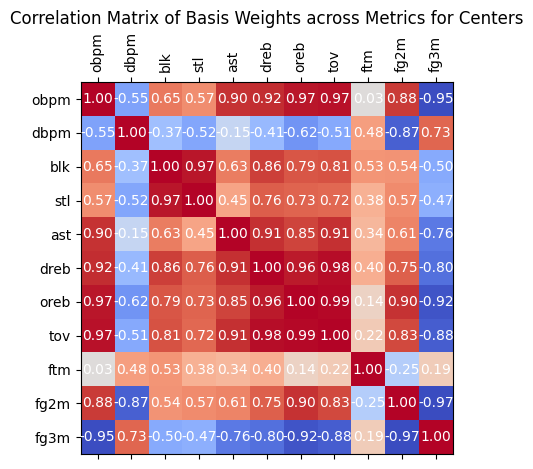

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Centers)')

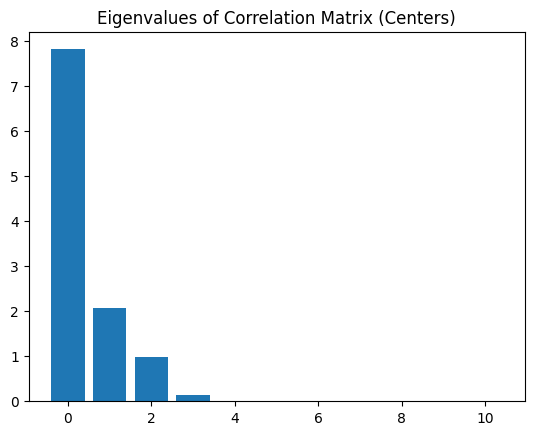

In [29]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Centers")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Centers)")

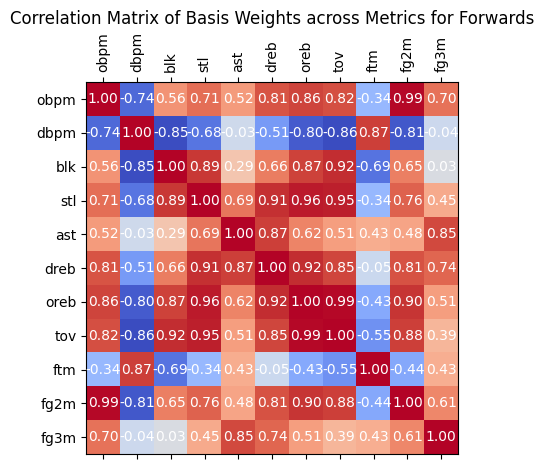

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Forwards)')

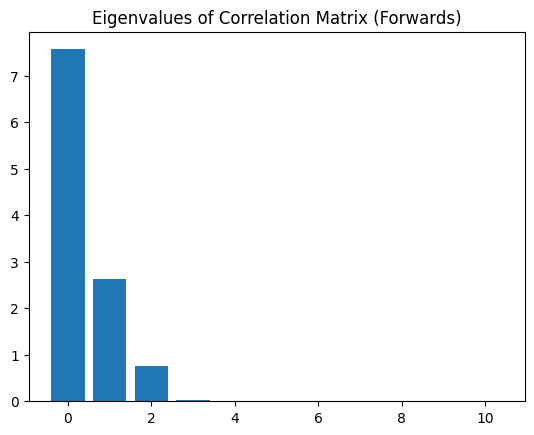

In [31]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T + metric_weight_tensor[:,1,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Forwards")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Forwards)")

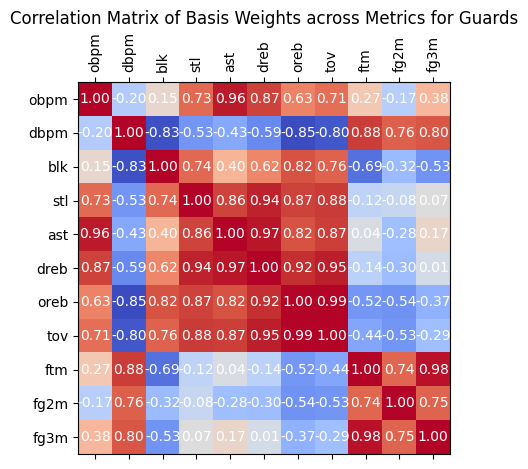

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Guards)')

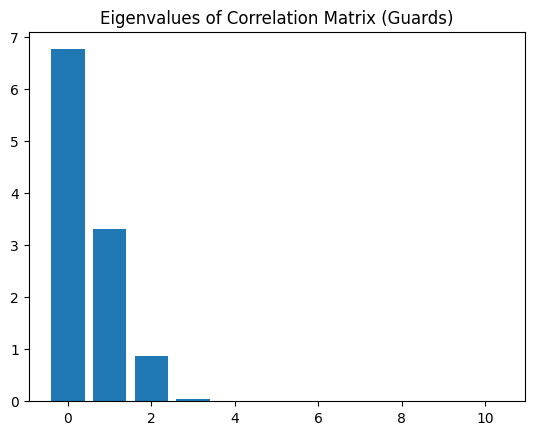

In [32]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T + metric_weight_tensor[:,2,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Guards")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Guards)")

### Use a Covariate Space which is Continuous
The idea is to perform PCA on matrix of career averages of desired metrics, and use those values as my X matrix

In [6]:
agg_dict = {"obpm":"mean", "dbpm":"mean", "bpm":"mean", 
            "minutes":"sum", "dreb": "sum", "fta":"sum", "ftm":"sum", "oreb":"sum",
            "ast":"sum", "tov":"sum", "fg2m":"sum", "fg3m":"sum", "fg3a":"sum", "fg2a":"sum", "blk":"sum", "stl":"sum"}
data["total_minutes"] = data["median_minutes_per_game"] * data["games"]

In [7]:
agged_data = data.groupby("id").agg(agg_dict).reset_index()

In [8]:
agged_data["ft_pct"] = agged_data["ftm"] / agged_data["fta"]
agged_data["fg2_pct"] = agged_data["fg2m"] / agged_data["fg2a"]
agged_data["fg3_pct"] = agged_data["fg3m"] / agged_data["fg3a"]

In [9]:
agged_data["dreb_rate"] = agged_data["dreb"] / agged_data["minutes"]
agged_data["oreb_rate"] = agged_data["oreb"] / agged_data["minutes"]
agged_data["ast_rate"] = agged_data["ast"] / agged_data["minutes"]
agged_data["tov_rate"] = agged_data["tov"] / agged_data["minutes"]
agged_data["blk_rate"] = agged_data["blk"] / agged_data["minutes"]
agged_data["stl_rate"] = agged_data["stl"] / agged_data["minutes"]

In [10]:
agged_data.fillna(0, inplace=True)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
latent_metrics = ["obpm","dbpm","minutes","ft_pct","fg2_pct","fg3_pct","dreb_rate","oreb_rate","ast_rate","tov_rate","blk_rate","stl_rate"]

In [13]:
X = StandardScaler().fit_transform(agged_data[latent_metrics])

In [44]:
X.min()

-15.255610894168898

In [14]:
pca_x = PCA(whiten=True).fit(X)

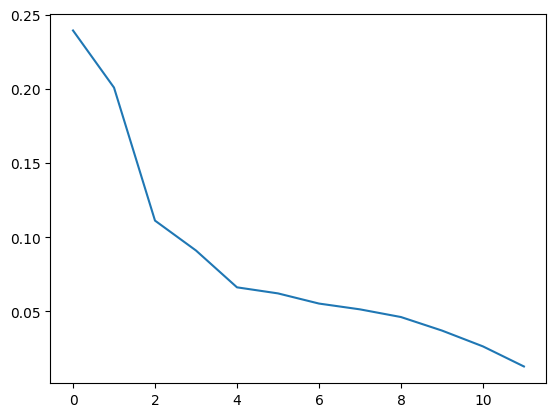

In [46]:
plt.plot(pca_x.explained_variance_ratio_)

use first 4 / 5 (elbow method)

In [15]:
X_pca = pca_x.transform(X)

In [52]:
X_pca.max(axis=0)

array([ 8.61052918,  8.34976868, 11.67163369, 12.94545333, 11.3279258 ,
       15.00657375, 11.92085075,  9.874949  ,  7.59276006, 11.6725354 ,
       18.61864998,  8.41735389])

In [24]:
covariate_X = MinMaxScaler().fit_transform(X_pca[:, 0:3])

In [17]:
covariate_size = covariate_X.shape[1]

In [25]:
covariate_X

array([[0.36975771, 0.51310516, 0.38690259],
       [0.41357241, 0.48757496, 0.41582094],
       [0.47842683, 0.48461362, 0.41334934],
       ...,
       [0.42329836, 0.50647112, 0.43363703],
       [0.49054998, 0.42826084, 0.41850964],
       [0.40129969, 0.48365651, 0.40092352]])

### Fit Model

In [26]:
with pm.Model() as fda_model:
    
    fixed_effects = pm.MutableData("X", covariate_X) ### X data (latent space)
    for data_entity in data_set:
        output = data_entity["output"]
        metric = data_entity["metric"]
        mask = data_entity["mask"]
        exposure_data = data_entity["exposure_data"]
        output_data = data_entity["output_data"]
        exposure = pm.MutableData(f"exposure_{metric}", exposure_data[mask].flatten())
        cov_func = pm.gp.cov.ExpQuad(1, ls=1)
        gp = pm.gp.HSGP(m=[10], c=4.0, cov_func=cov_func)
        basis_weights =  pm.math.stack([gp.prior(f"basis_weights_{metric}_{i}", X = basis[:, None]) for i in range(covariate_size)], axis = 0)
        mu =  pm.math.dot(fixed_effects, basis_weights) ### get mu

        if output == "gaussian":
            sd = pm.Exponential(f"sigma_{metric}", 1.0)
            ## likelihood
            y = pm.Normal(f"likelihood_{metric}", mu = pm.math.flatten(mu[mask]), sigma = sd / exposure, observed=output_data[mask].flatten())
        
        elif output == "poisson":
            y = pm.Poisson(f"likelihood_{metric}", mu = pm.math.exp(pm.math.flatten(mu[mask]) + exposure), observed = output_data[mask].flatten())
        
        elif output == "binomial":
            y = pm.Binomial(f"likelihod_{metric}", logit_p = pm.math.flatten(mu[mask]), n = exposure, observed=output_data[mask].flatten())
    
    # gv = pm.model_graph.model_to_graphviz()
    # gv.format = 'png'
    # gv.render(filename='model_graph')

with fda_model:
    print("fitting model")
    trace = pm.sample()

az.to_netcdf(trace, "data/uncorrelated_metrics_pca.ncdf")

fitting model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_obpm_0_hsgp_coeffs_, basis_weights_obpm_1_hsgp_coeffs_, basis_weights_obpm_2_hsgp_coeffs_, sigma_obpm, basis_weights_dbpm_0_hsgp_coeffs_, basis_weights_dbpm_1_hsgp_coeffs_, basis_weights_dbpm_2_hsgp_coeffs_, sigma_dbpm, basis_weights_blk_0_hsgp_coeffs_, basis_weights_blk_1_hsgp_coeffs_, basis_weights_blk_2_hsgp_coeffs_, basis_weights_stl_0_hsgp_coeffs_, basis_weights_stl_1_hsgp_coeffs_, basis_weights_stl_2_hsgp_coeffs_, basis_weights_ast_0_hsgp_coeffs_, basis_weights_ast_1_hsgp_coeffs_, basis_weights_ast_2_hsgp_coeffs_, basis_weights_dreb_0_hsgp_coeffs_, basis_weights_dreb_1_hsgp_coeffs_, basis_weights_dreb_2_hsgp_coeffs_, basis_weights_oreb_0_hsgp_coeffs_, basis_weights_oreb_1_hsgp_coeffs_, basis_weights_oreb_2_hsgp_coeffs_, basis_weights_tov_0_hsgp_coeffs_, basis_weights_tov_1_hsgp_coeffs_, basis_weights_tov_2_hsgp_coeffs_, basis_weights_ftm_0_hs

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40792 seconds.


'data/uncorrelated_metrics_pca.ncdf'

<Axes: xlabel='sigma_obpm', ylabel='sigma_dbpm'>

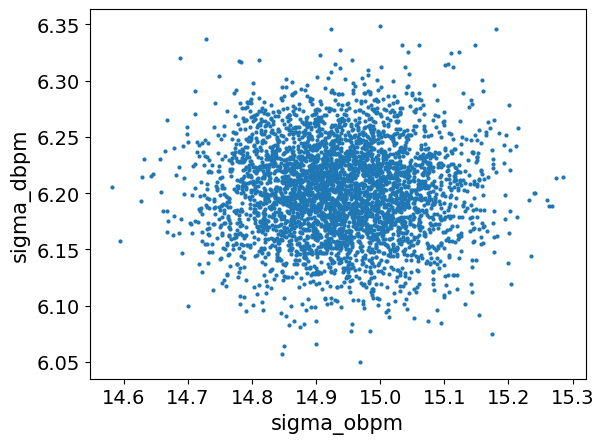

In [29]:
az.plot_pair(trace, var_names=["sigma_obpm","sigma_dbpm"])

In [30]:
recovered_basis_weights = [az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size)])[["mean"]].to_numpy().reshape((3,27)) for metric in metrics]

    

In [31]:
metric_weight_tensor = np.stack(recovered_basis_weights)

In [32]:
metric_weight_tensor.shape

(11, 3, 27)

In [38]:
predicted_curves = np.einsum("ij,ljk->ilk", covariate_X, metric_weight_tensor)

In [39]:
data = data.sort_values(by=["id","year"])

In [60]:
name_mapper = data[["name", "id"]].drop_duplicates(ignore_index=True)

In [70]:
from scipy.special import expit

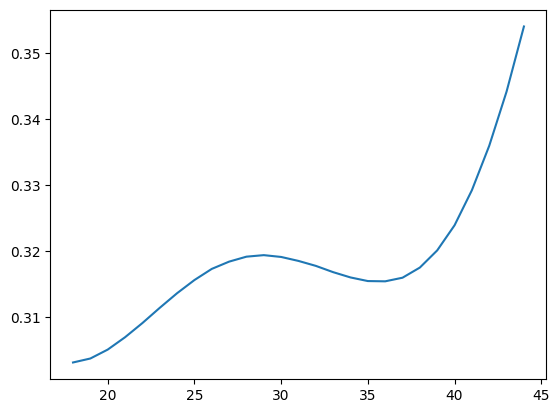

In [77]:
plt.plot(basis, expit(predicted_curves[481,-1,:]) )

In [65]:
name_mapper[name_mapper["name"] == "Kobe Bryant"]

,name,id
391,Kobe Bryant,977


In [64]:
data_set[2]["exposure_data"][481,:]

array([       nan,        nan,        nan, 7.93262215, 7.43792591,
       7.829968  , 7.93262215, 7.93262215, 7.92035206, 7.76000941,
       7.71555765, 7.90792954, 7.90792954, 7.88261173, 7.84339102,
       7.88261173, 7.85663624, 7.58634591, 7.76000941, 7.829968  ,
       7.86970833, 7.63677677,        nan,        nan,        nan,
              nan,        nan])